In [53]:
from typing import List, Union, Dict
import pathlib as pl
import json
import os
import re
from datetime import datetime

import openai
import numpy as np
import pandas as pd
from sklearn import metrics as skm

from ai4chem.data import Deep4ChemDataset, ChemFluorDataset, split_on_unique_smiles

with open('/Users/azadoks/.zshrc.d/10_openai_bot.sh', 'r') as f:
    api_key = f.read().split('=')[1].strip()

client = openai.OpenAI(api_key=api_key)

In [4]:
def get_system_message(property_name: str) -> str:
    return f"You predict properties of molecules with high accuracy to assist chemists. You are to predict the {property_name} maximum wavelength in nanometers of the provided molecule when dissolved in the provided solvent."

def get_user_message(row, representation: Union[str, List[str]]="smiles") -> str:
    def _get_molecule_line(row, representation: str) -> str:
        return f"Molecule {representation}: {row[f'chromophore_{representation}']}"
    def _get_solvent_line(row, representation: str) -> str:
        return f"Solvent {representation}: {row[f'solvent_{representation}']}"

    if isinstance(representation, str):
        molecule_lines = _get_molecule_line(row, representation)
        solvent_lines = _get_solvent_line(row, representation)
    else:
        molecule_lines = "\n".join([_get_molecule_line(row, rep) for rep in representation])
        solvent_lines = "\n".join([_get_solvent_line(row, rep) for rep in representation])

    return f'{molecule_lines}\n\n{solvent_lines}'

def get_train_conversation(row, property_name: str, representation: Union[str, List[str]]="smiles") -> Dict:
    messages = []
    messages.append({'role': 'system', 'content': get_system_message(property_name)})
    messages.append({'role': 'user', 'content': get_user_message(row, representation)})
    property_key = f'{property_name.lower()}_max'
    messages.append({'role': 'assistant', 'content': f'{int(row[property_key]):3d} nm'})
    return {'messages': messages}

def get_test_conversation(row, property_name: str, representation: Union[str, List[str]]="smiles") -> Dict:
    messages = []
    messages.append({'role': 'system', 'content': get_system_message(property_name)})
    messages.append({'role': 'user', 'content': get_user_message(row, representation)})
    property_key = f'{property_name.lower()}_max'
    return {'messages': messages}, f'{int(row[property_key]):3d} nm'

def get_prompt(row, property_name: str, representation: Union[str, List[str]]="smiles") -> str:
    return f"What is the {property_name} maximum wavelength of {row[f'chromophore_{representation}']} dissolved in {row[f'solvent_{representation}']}?"

def get_completion(row, property_name: str) -> str:
    property_key = f'{property_name.lower()}_max'
    return f' {int(row[property_key]):3d} nm'

def get_train_prompt_completion(row, property_name: str, representation: Union[str, List[str]]="smiles") -> Dict:
    return {
        'prompt': get_prompt(row, property_name, representation),
        'completion': get_completion(row, property_name)
    }

def get_inverse_prompt(row, property_name: str, representation: str="smiles") -> str:
    property_key = f'{property_name.lower()}_max'
    return f"What is a chromophore + solvent pair with an {property_name} maximum wavelength of {int(row[property_key]):3d} nm?"

def get_inverse_completion(row, representation: str="smiles") -> str:
    return f"Molecule {representation}: {row[f'chromophore_{representation}']}$$$ Solvent {representation}: {row[f'solvent_{representation}']}$$$"

def get_inverse_prompt_completion(row, property_name: str, representation: str="smiles") -> Dict:
    return {
        'prompt': get_inverse_prompt(row, property_name, representation),
        'completion': get_inverse_completion(row, representation)
    }

def write_jsonl(data: list, filename: os.PathLike) -> None:
    with open(filename, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

def count_tokens(data: List[Dict]) -> int:
    return sum(
        gpt_num_tokens_from_messages(row['messages'], model="gpt-3.5-turbo-0613")
        for row in data
    )

def make_completion_conversations(data: pd.DataFrame, property_name: str, direction: str, representation: Union[str, List[str]]="smiles") -> List[Dict]:
    if direction == 'forward':
        return data.apply(lambda x: get_train_prompt_completion(x, property_name, representation), axis=1)
    if direction == 'inverse':
        return data.apply(lambda x: get_inverse_prompt_completion(x, property_name, representation), axis=1)
    raise ValueError(f"Invalid direction: {direction}")

In [89]:
def load_jsonl(filename: os.PathLike) -> List[dict]:
    data = []
    with open(filename, 'r') as f:
        for line in f.readlines():
            data.append(json.loads(line.strip()))
    return data

def predict(job_id: str, prompts: List[str], batch_size: int=20) -> List:
    response = client.fine_tuning.jobs.retrieve(job_id)
    fine_tuned_model_id = response.fine_tuned_model

    batched_prompts = [prompts[i:i+batch_size] for i in range(0, len(prompts), batch_size)]
    responses = []
    for prompts_batch in batched_prompts:
        responses_batch = client.completions.create(
            model=fine_tuned_model_id,
            prompt=prompts_batch,
            stop='nm',
            temperature=0
        )
        responses.append(responses_batch.to_dict())
    return responses

def generate(job_id: str, prompts, temperature: float=0.5, max_tokens: int=256) -> List:
    response = client.fine_tuning.jobs.retrieve(job_id)
    fine_tuned_model_id = response.fine_tuned_model

    responses = []
    for prompt in prompts:
        if isinstance(prompt, dict):
            prompt = prompt['prompt']
        response = client.completions.create(
            model=fine_tuned_model_id,
            prompt=prompt,
            stop='###',
            temperature=temperature,
            max_tokens=max_tokens
        )
        responses.append(response.to_dict())

    return responses

In [6]:
chemfluor_path = '../data/chemfluor/data.csv'
deep4chem_path = '../data/deep4chem/data.csv'

chemfluor = ChemFluorDataset(chemfluor_path, canonicalize_smiles=True)
deep4chem = Deep4ChemDataset(deep4chem_path, canonicalize_smiles=True)

combined_df = pd.concat([chemfluor.clean_data, deep4chem.clean_data], ignore_index=True).reset_index(drop=True)
n_unique_smiles = len(combined_df['chromophore_smiles'].unique())

In [95]:
n_trains = (10, 100, 1000)
seed = 9997
direction = 'forward'
property_names = ('emission', 'absorption')
representation = 'smiles'
model_name = 'babbage-002'

n_test = 5000

def get_pred(choice_text):
    match = re.search(r'(\d+)', choice_text.strip())
    if match is not None:
        return int(match.group(0))
    return None

for n_train in n_trains:
    for property_name in property_names:
        experiment_glob = pl.Path('../data/').glob(f'{n_train:d}{property_name[:1].lower()}{direction[:1].lower()}{model_name[:1].lower()}*/')
        experiment_name = list(experiment_glob)[0].name

        # experiment_name = f'{n_train:d}{property_name[:1].lower()}{direction[:1].lower()}{model_name[:1].lower()}{datetime.now().strftime("%d%H%M")}'
        experiment_data_path = pl.Path(f'../data/{experiment_name}')
        experiment_data_path.mkdir(exist_ok=True)
        with open(experiment_data_path / 'job_id.txt', 'r') as f:
            job_id = f.read().strip()

        test_convos = load_jsonl(experiment_data_path / 'test.jsonl')

        test_prompts = [conv['prompt'] for conv in test_convos[:n_test]]
        y_test = [int(conv['completion'].split()[0].strip()) for conv in test_convos[:n_test]]

        test_responses = predict(job_id, test_prompts)
        y_hat_test = []
        for batch_response in test_responses:
            tmp = [get_pred(choice['text']) for choice in batch_response['choices']]
            y_hat_test.extend(tmp)

        with open(f'../data/{experiment_name}/test_preds.json', 'w') as f:
            json.dump({'y': y_test, 'y_hat': y_hat_test}, f)


In [12]:
import pathlib as pl
import json
import re
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as skm

direction = 'forward'
model_name = 'babbage-002'

test_preds = {}
n_trains = (10, 100, 1000)
property_names = ('emission', 'absorption')

for n_train in n_trains:
    for property_name in property_names:
        experiment_glob = pl.Path('../data/').glob(f'{n_train:d}{property_name[:1].lower()}{direction[:1].lower()}{model_name[:1].lower()}*/')
        experiment_name = list(experiment_glob)[0].name
        with open(pl.Path('../data/') / experiment_name / 'test_preds.json', 'r') as f:
            test_preds[experiment_name] = json.load(f)

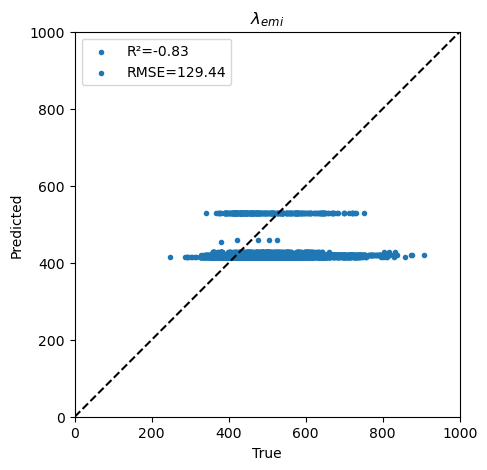

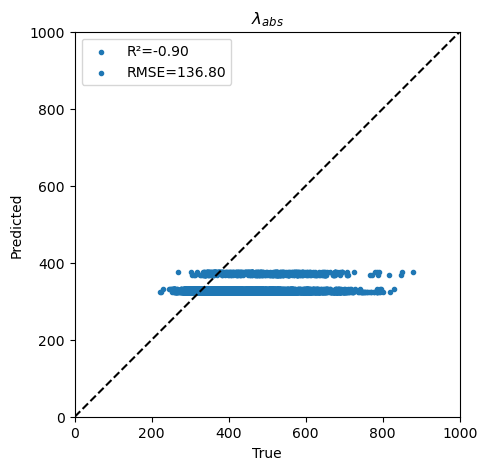

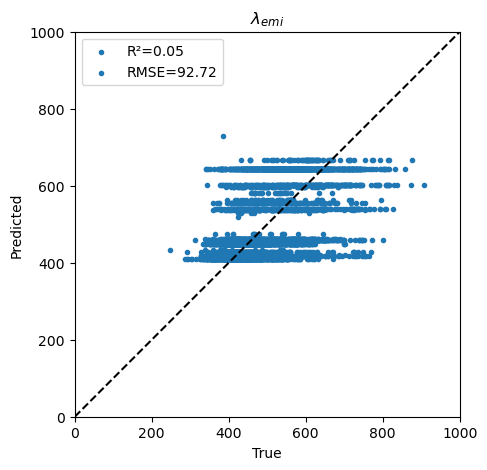

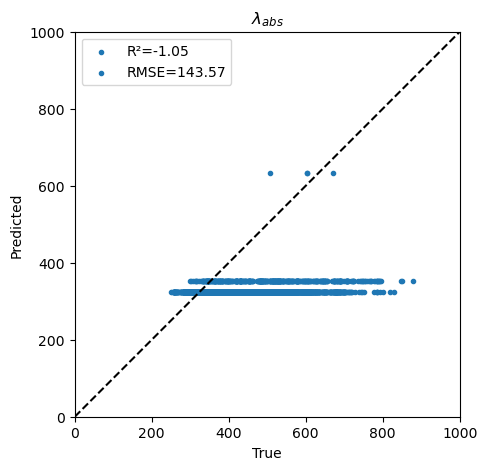

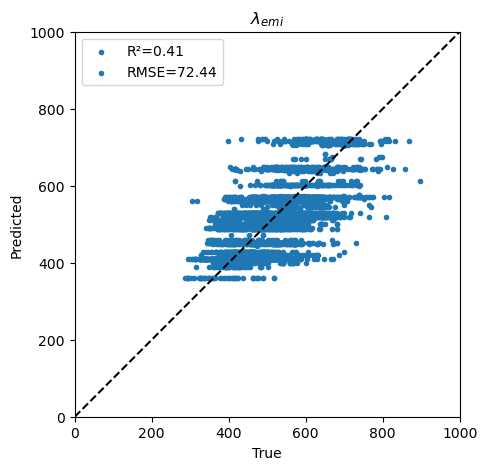

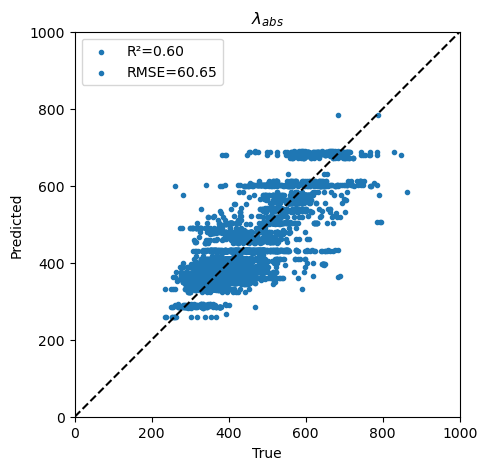

In [15]:
import matplotlib.pyplot as plt

for experiment_name in test_preds.keys():
    fig, ax = plt.subplots(figsize=(5, 5))

    m = re.match('(\d+)([ea])([fi])([bdg])(\d\d)(\d\d)(\d\d)', experiment_name)
    n_train = m.group(1)
    property_name = 'emission' if m.group(2) == 'e' else 'absorption'
    direction = 'forward' if m.group(3) == 'f' else 'inverse'
    model_name = {'b': 'babbage-002', 'd': 'davinci-002', 'g': 'gpt-3.5-turbo'}[m.group(4)]

    y = np.array(test_preds[experiment_name]['y'])
    y_hat = np.array([y if y is not None else np.nan for y in test_preds[experiment_name]['y_hat']])
    nanmask = np.isnan(y) | np.isnan(y_hat)

    r2 = skm.r2_score(y[~nanmask], y_hat[~nanmask])
    rmse = np.sqrt(skm.mean_squared_error(y[~nanmask], y_hat[~nanmask]))
    mae = skm.mean_absolute_error(y[~nanmask], y_hat[~nanmask])

    ax.set_title(f'$\lambda_{{{property_name[:3]}}}$')
    ax.plot([0, 1000], [0, 1000], 'k--')
    ax.scatter(y, y_hat, marker='.', c='tab:blue', label=f'R²={r2:.2f}')
    ax.scatter([-10], [-10], marker='.', c='tab:blue', label=f'RMSE={rmse:.2f}')
    # ax.scatter([-10], [-10], marker='.', c='tab:blue', label=f'MAE={mae:.2f}')
    ax.set_aspect('equal')
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 1000)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')

    ax.legend()

    fig.savefig(f'../plots/{experiment_name}.png', dpi=300)

In [ ]:
for experiment_name in ('')